In [13]:
from pathlib import Path
import random

random.seed(42)
dataset_path = Path("mnt/d/SIDD_Medium_Srgb/Data")
pairs = []

scene_folders = [f for f in dataset_path.iterdir() if f.is_dir()]

for scene_folder in scene_folders:
    gt_files = list(scene_folder.glob('*_GT_SRGB_*.PNG')) + list(scene_folder.glob('*_GT_SRGB_*.png'))
    noisy_files = list(scene_folder.glob('*_NOISY_SRGB_*.PNG')) + list(scene_folder.glob('*_NOISY_SRGB_*.png'))
    
    for noisy_file in noisy_files:
        noisy_parts = noisy_file.stem.split('_')
        noisy_number = noisy_parts[-1] if noisy_parts else None
        for gt_file in gt_files:
            gt_parts = gt_file.stem.split('_')
            gt_number = gt_parts[-1] if gt_parts else None
            if noisy_number and gt_number and noisy_number == gt_number:
                pairs.append((noisy_file, gt_file))
                break

print(f"\n✓ Znaleziono {len(pairs)} par obrazów")
random.shuffle(pairs)
n = len(pairs)
train_pairs = pairs[:int(0.7*n)]
val_pairs = pairs[int(0.7*n):int(0.85*n)]
test_pairs = pairs[int(0.85*n):]

print(f"\nPodział danych:")
print(f"Train: {len(train_pairs)}, Val: {len(val_pairs)}, Test: {len(test_pairs)}")


✓ Znaleziono 320 par obrazów

Podział danych:
Train: 224, Val: 48, Test: 48


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cpu


In [15]:
class DenoisingDataset(Dataset):
    def __init__(self, pairs, transform=None, img_size=256, is_train=False):
        self.pairs = pairs
        self.img_size = img_size
        self.is_train = is_train
        
        if is_train:
            # Data augmentation dla treningu (zapobieganie overfittingowi)
            self.transform = transform or transforms.Compose([
                transforms.Resize((img_size + 32, img_size + 32)),
                transforms.RandomCrop(img_size),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.ToTensor()
            ])
        else:
            # Bez augmentacji dla val/test
            self.transform = transform or transforms.Compose([
                transforms.Resize((img_size, img_size)),
                transforms.ToTensor()
            ])
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        noisy_path, clean_path = self.pairs[idx]
        
        noisy_img = Image.open(noisy_path).convert('RGB')
        clean_img = Image.open(clean_path).convert('RGB')
        
        # Zastosuj te same transformacje do obu obrazów
        seed = np.random.randint(2147483647)
        if self.is_train:
            torch.manual_seed(seed)
            noisy_tensor = self.transform(noisy_img)
            torch.manual_seed(seed)
            clean_tensor = self.transform(clean_img)
        else:
            noisy_tensor = self.transform(noisy_img)
            clean_tensor = self.transform(clean_img)
        
        return noisy_tensor, clean_tensor


train_dataset = DenoisingDataset(train_pairs, is_train=True)
val_dataset = DenoisingDataset(val_pairs, is_train=False)
test_dataset = DenoisingDataset(test_pairs, is_train=False)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [ ]:
class ConvAutoencoder(nn.Module):
    def __init__(self, dropout_rate=0.1):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder - zmniejszony dropout i dodany BatchNorm dla lepszej stabilności
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(dropout_rate),  # Dropout tylko w encoderze
            nn.MaxPool2d(2, 2),  # 256x256 -> 128x128
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(dropout_rate),
            nn.MaxPool2d(2, 2),  # 128x128 -> 64x64
            
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # Brak dropout na końcu encoder - zachowujemy informację
        )
        
        # Decoder - bez dropout (zachowuje szczegóły) i używa ConvTranspose2d zamiast Upsample
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 2, stride=2),  # 64x64 -> 128x128
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # Brak dropout w decoderze - zachowujemy szczegóły
            
            nn.ConvTranspose2d(128, 64, 2, stride=2),  # 128x128 -> 256x256
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # Brak dropout w decoderze
            
            nn.Conv2d(64, 3, 3, padding=1),
            nn.Sigmoid()  # Normalizacja do [0,1]
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = ConvAutoencoder(dropout_rate=0.1).to(device)

In [17]:
# Setup TensorBoard
from torch.utils.tensorboard import SummaryWriter
import os

log_dir = 'runs/denoising_experiment'
writer = SummaryWriter(log_dir)
print(f"TensorBoard logs saved to: {log_dir}")
print("Uruchom: tensorboard --logdir=runs")

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        
    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

early_stopping = EarlyStopping(patience=5, min_delta=0.0001)

def train_epoch(model, loader, criterion, optimizer, epoch, writer):
    model.train()
    total_loss = 0
    for batch_idx, (noisy, clean) in enumerate(loader):
        noisy, clean = noisy.to(device), clean.to(device)
        
        optimizer.zero_grad()
        output = model(noisy)
        loss = criterion(output, clean)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_idx % 5 == 0:
            global_step = epoch * len(loader) + batch_idx
            writer.add_scalar('Train/BatchLoss', loss.item(), global_step)
            writer.add_scalar('Train/LearningRate', optimizer.param_groups[0]['lr'], global_step)
    
    avg_loss = total_loss / len(loader)
    writer.add_scalar('Train/EpochLoss', avg_loss, epoch)
    return avg_loss

def validate(model, loader, criterion, epoch, writer):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for noisy, clean in loader:
            noisy, clean = noisy.to(device), clean.to(device)
            output = model(noisy)
            loss = criterion(output, clean)
            total_loss += loss.item()
    
    avg_loss = total_loss / len(loader)
    writer.add_scalar('Validation/EpochLoss', avg_loss, epoch)
    return avg_loss
num_epochs = 20
train_losses = []
val_losses = []

best_val_loss = float('inf')
best_model_state = None

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, epoch, writer)
    val_loss = validate(model, val_loader, criterion, epoch, writer)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Zapisz najlepszy model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
    
    # Early stopping
    if early_stopping(val_loss):
        print(f"\nEarly stopping at epoch {epoch+1}")
        model.load_state_dict(best_model_state)
        break
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

model.load_state_dict(best_model_state)
writer.close()

# Zapisz model
model_path = 'denoising_model.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'model_class': 'ConvAutoencoder',
    'dropout_rate': 0.1,
    'img_size': 256
}, model_path)
print(f"\nModel zapisany do: {model_path}")

TensorBoard logs saved to: runs/denoising_experiment
Uruchom: tensorboard --logdir=runs
Epoch 1/20 - Train Loss: 0.018675, Val Loss: 0.041589, LR: 0.001000


KeyboardInterrupt: 

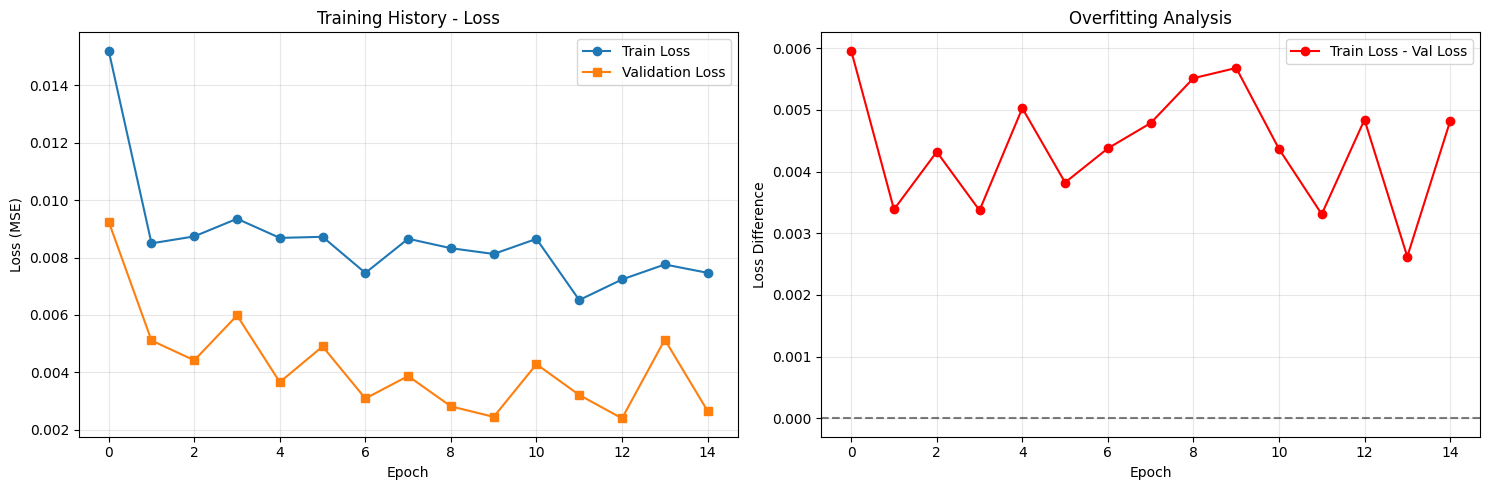

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(train_losses, label='Train Loss', marker='o')
axes[0].plot(val_losses, label='Validation Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Training History - Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

overfitting_gap = [t - v for t, v in zip(train_losses, val_losses)]
axes[1].plot(overfitting_gap, label='Train Loss - Val Loss', marker='o', color='red')
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss Difference')
axes[1].set_title('Overfitting Analysis')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr

try:
    from skimage.metrics import structural_similarity_index as ssim
except ImportError:
    from skimage.metrics import structural_similarity as ssim

def calculate_metrics(pred, target):
    """Oblicza PSNR i SSIM dla batcha obrazów"""
    batch_psnr = []
    batch_ssim = []
    
    for i in range(pred.shape[0]):
        # Konwertuj z tensor do numpy
        pred_np = pred[i].cpu().permute(1, 2, 0).numpy()
        target_np = target[i].cpu().permute(1, 2, 0).numpy()
        
        # Ogranicz do [0,1]
        pred_np = np.clip(pred_np, 0, 1)
        target_np = np.clip(target_np, 0, 1)
        
        # PSNR
        psnr_val = psnr(target_np, pred_np, data_range=1.0)
        batch_psnr.append(psnr_val)
        
        # SSIM - kompatybilność z różnymi wersjami scikit-image
        try:
            # Nowa wersja (scikit-image >= 0.19)
            ssim_val = ssim(target_np, pred_np, data_range=1.0, channel_axis=2, win_size=7)
        except TypeError:
            # Stara wersja (scikit-image < 0.19)
            ssim_val = ssim(target_np, pred_np, data_range=1.0, multichannel=True, win_size=7)
        batch_ssim.append(ssim_val)
    
    return np.mean(batch_psnr), np.mean(batch_ssim)

# Ewaluacja na zbiorze testowym
model.eval()
test_losses = []
test_psnrs = []
test_ssims = []

with torch.no_grad():
    for noisy, clean in test_loader:
        noisy, clean = noisy.to(device), clean.to(device)
        output = model(noisy)
        
        loss = criterion(output, clean)
        test_losses.append(loss.item())
        
        psnr_val, ssim_val = calculate_metrics(output, clean)
        test_psnrs.append(psnr_val)
        test_ssims.append(ssim_val)

avg_test_loss = np.mean(test_losses)
avg_test_psnr = np.mean(test_psnrs)
avg_test_ssim = np.mean(test_ssims)

print("\n" + "="*60)
print("EWALUACJA MODELU NA ZBIORZE TESTOWYM")
print("="*60)
print(f"MSE Loss: {avg_test_loss:.6f}")
print(f"PSNR: {avg_test_psnr:.2f} dB")
print(f"SSIM: {avg_test_ssim:.4f}")
print("="*60)



EWALUACJA MODELU NA ZBIORZE TESTOWYM
MSE Loss: 0.002937
PSNR: 26.87 dB
SSIM: 0.7730


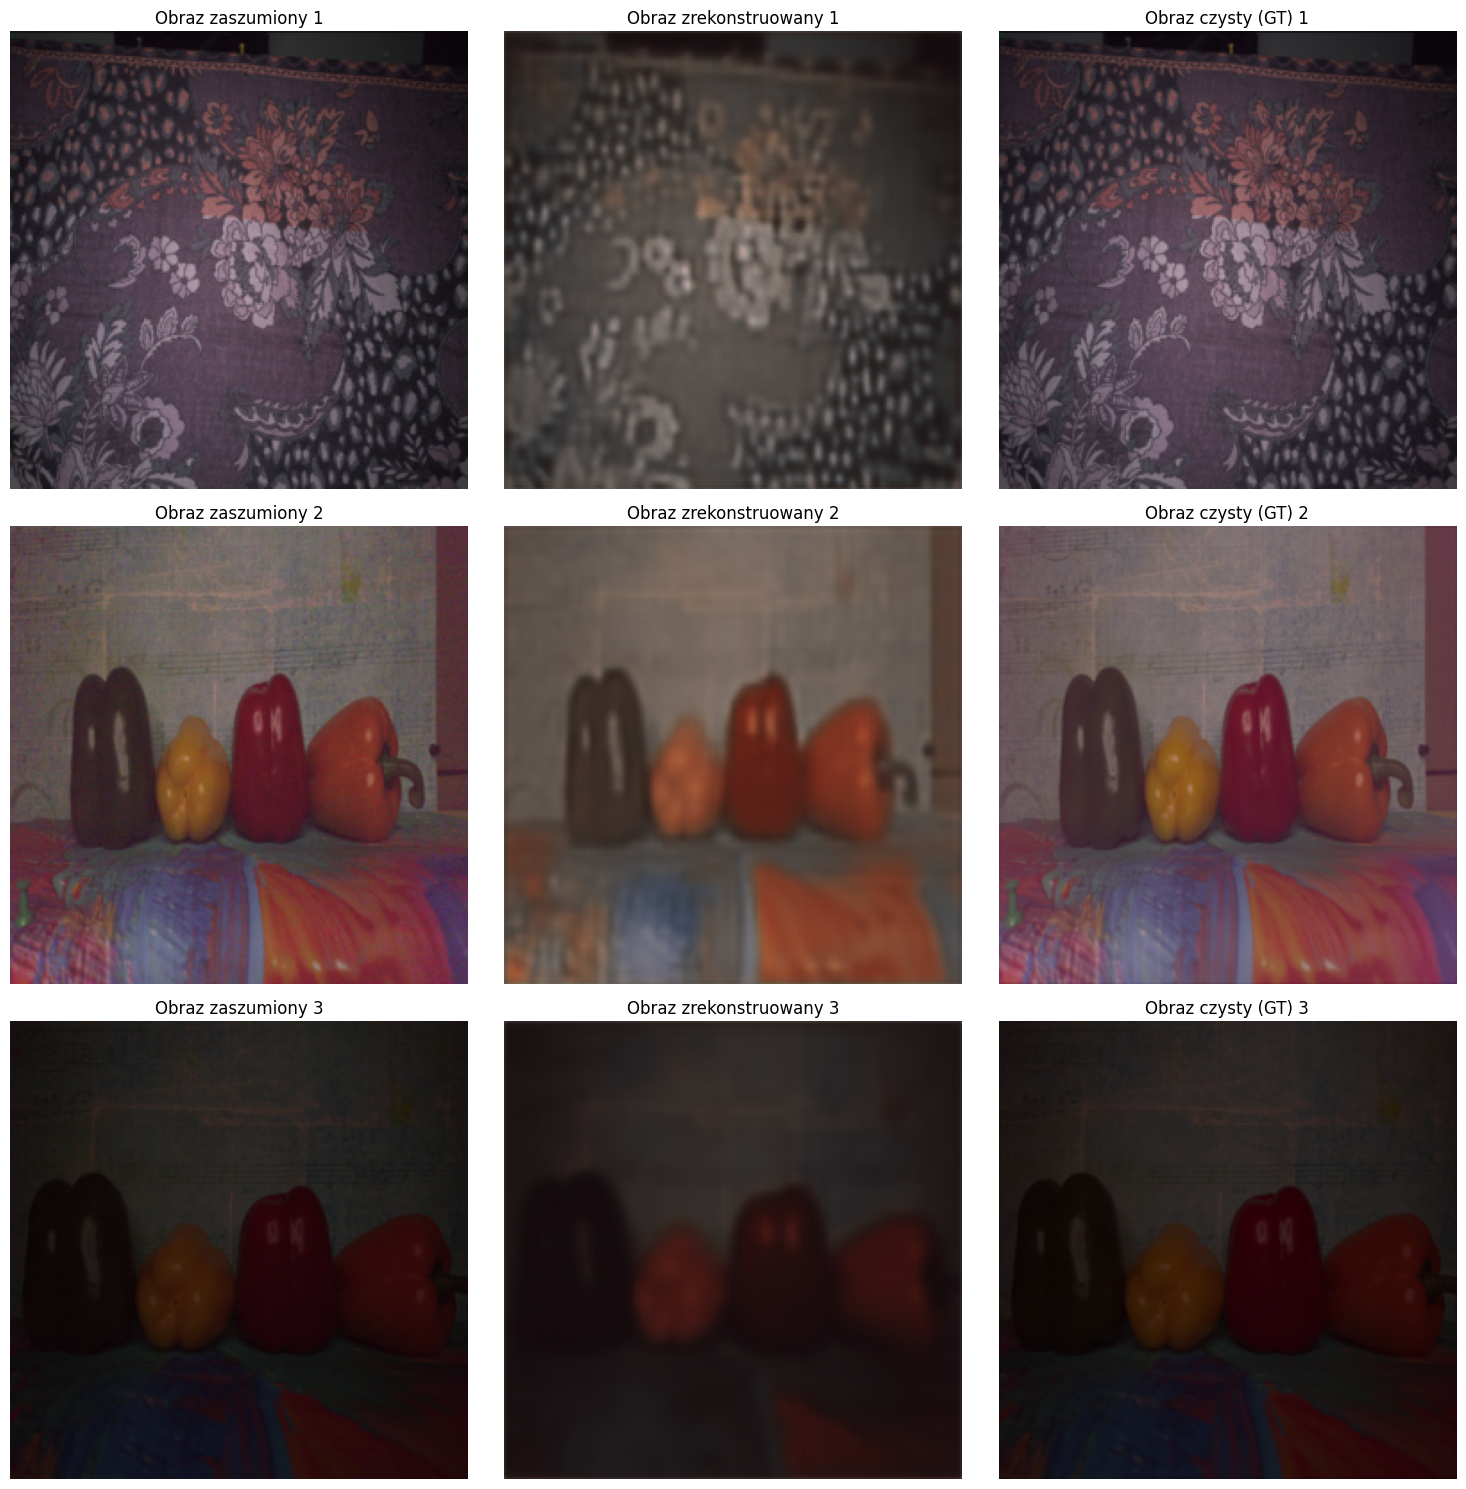

In [ ]:
# Wizualizacja wyników na przykładowych obrazach testowych
model.eval()
with torch.no_grad():
    noisy, clean = next(iter(test_loader))
    noisy, clean = noisy.to(device), clean.to(device)
    output = model(noisy)
    
    # Wyświetl pierwsze 3 obrazy z batcha
    n_images = min(3, output.shape[0])
    fig, axes = plt.subplots(n_images, 3, figsize=(15, 5*n_images))
    
    if n_images == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(n_images):
        # Konwertuj tensory do numpy i upewnij się, że są w zakresie [0, 1] dla kolorów RGB
        noisy_np = noisy[i].cpu().permute(1, 2, 0).numpy()
        output_np = output[i].cpu().permute(1, 2, 0).numpy()
        clean_np = clean[i].cpu().permute(1, 2, 0).numpy()
        
        # Obetnij wartości do zakresu [0, 1] dla poprawnego wyświetlania kolorów
        noisy_np = np.clip(noisy_np, 0, 1)
        output_np = np.clip(output_np, 0, 1)
        clean_np = np.clip(clean_np, 0, 1)
        
        # Wyświetl obrazy w kolorze RGB
        axes[i, 0].imshow(noisy_np, vmin=0, vmax=1)
        axes[i, 0].set_title(f'Obraz zaszumiony {i+1}')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(output_np, vmin=0, vmax=1)
        axes[i, 1].set_title(f'Obraz zrekonstruowany {i+1}')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(clean_np, vmin=0, vmax=1)
        axes[i, 2].set_title(f'Obraz czysty (GT) {i+1}')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

In [ ]:
print("\n" + "="*60)
print("ZASTOSOWANE METODY ZAPOBIEGANIA OVERFITTINGOWI")
print("="*60)
print("\n1. DATA AUGMENTATION:")
print("   - RandomCrop: losowe przycinanie obrazów")
print("   - RandomHorizontalFlip: losowe odbicie poziome (p=0.5)")
print("   - RandomVerticalFlip: losowe odbicie pionowe (p=0.5)")
print("   - Zwiększa różnorodność danych treningowych")
print("\n2. DROPOUT:")
print("   - Dropout2d (rate=0.1) TYLKO w encoderze")
print("   - Losowe wyłączanie 10% neuronów podczas treningu w encoderze")
print("   - Brak dropout w decoderze - zachowuje szczegóły podczas rekonstrukcji")
print("   - Zapobiega zapamiętywaniu specyficznych cech")
print("\n2b. BATCH NORMALIZATION:")
print("   - BatchNorm2d w każdej warstwie konwolucyjnej")
print("   - Stabilizuje trening i przyspiesza konwergencję")
print("   - Pomaga w generalizacji modelu")
print("\n3. ARCHITEKTURA:")
print("   - ConvTranspose2d zamiast Upsample (lepsza rekonstrukcja szczegółów)")
print("   - Encoder: kompresja z MaxPool2d")
print("   - Decoder: dekompresja z ConvTranspose2d")
print("\n4. EARLY STOPPING:")
print("   - Patience: 5 epok")
print("   - Zatrzymuje trening gdy val loss przestaje się poprawiać")
print("   - Zapobiega przeuczeniu modelu")
print("\n5. LEARNING RATE SCHEDULING:")
print("   - ReduceLROnPlateau: zmniejsza LR gdy val loss przestaje spadać")
print("   - Factor: 0.5, Patience: 3 epoki")
print("   - Pozwala na lepszą konwergencję")
print("\n6. PODZIAŁ DANYCH:")
print("   - 70% train, 15% validation, 15% test")
print("   - Walidacja w każdej epoce")
print("   - Monitoring różnicy między train a val loss")
print("="*60)


ZASTOSOWANE METODY ZAPOBIEGANIA OVERFITTINGOWI

1. DATA AUGMENTATION:
   - RandomCrop: losowe przycinanie obrazów
   - RandomHorizontalFlip: losowe odbicie poziome (p=0.5)
   - RandomVerticalFlip: losowe odbicie pionowe (p=0.5)
   - Zwiększa różnorodność danych treningowych

2. DROPOUT:
   - Dropout2d (rate=0.2) w warstwach konwolucyjnych
   - Losowe wyłączanie 20% neuronów podczas treningu
   - Zapobiega zapamiętywaniu specyficznych cech

3. EARLY STOPPING:
   - Patience: 5 epok
   - Zatrzymuje trening gdy val loss przestaje się poprawiać
   - Zapobiega przeuczeniu modelu

4. LEARNING RATE SCHEDULING:
   - ReduceLROnPlateau: zmniejsza LR gdy val loss przestaje spadać
   - Factor: 0.5, Patience: 3 epoki
   - Pozwala na lepszą konwergencję

5. PODZIAŁ DANYCH:
   - 70% train, 15% validation, 15% test
   - Walidacja w każdej epoce
   - Monitoring różnicy między train a val loss
